In [1]:
# importación de librerías
from math import floor, exp, ceil
import numpy as np
import cv2
from matplotlib import pyplot as plt # necesario para mostrar imágenes en jupyter

# Ejercicio A

## Cálculo del vector máscara

A continuación se muestran las funciones encargadas del calcular la máscara:

In [2]:
# función gaussiana para la máscara
kernel = lambda x, sigma: exp(-0.5 * ((x*x)/(sigma*sigma)))

# Función para calcular la máscara/kernel
def my_getGaussianKernel(sigma):
    # El tamaño de la máscara depende de sigma. Aplicando la estadística báisca, llegamos a que lo óptimo es tomar
    # 3sigma por cada lado. Por lo que el tamaño de la máscara será 6sigma + 1
    mascara = np.arange(-floor(3*sigma),floor(3*sigma + 1))
    # aplicamos la gaussiana a la máscara
    mascara = np.array([kernel(m, sigma) for m in mascara])
    # y la devolvemos normalizada
    return np.divide(mascara, np.sum(mascara))

La función `kernel` es una función auxiliar de la función `my_getGaussianKernel`. Ésta última está inspirada en la función de _OpenCV_ `getGaussianKernel` y su función es devolver la máscara que más tarde se usará para filtrar la imagen.

A diferencia de la función `getGaussianKernel` de _OpenCV_, `my_getGaussianKernel` calcula el tamaño de la máscara en función de $\sigma$:

$$ M\acute{a}scara = \bigg[\lfloor-3\sigma\rfloor,\lfloor3\sigma\rfloor\bigg] $$

por ejemplo, si $\sigma = 1$, la máscara tendría tamaño 7 y abarcaría el intervalo $[-3,3]$. El redondeo es necesario ya que $\sigma$ es un número real, pero la máscara sólo puede abarcar números enteros.

Una vez que la función obtiene el tamaño de la máscara, pasa a calcular cada valor de la misma. Para ello, se usa la siguiente expresión matemática definida en la función `kernel`:

$$ f(x) = exp \Bigg(-0.5 \cdot \frac{x^2}{\sigma^2} \Bigg)$$

Y, por último, la función normaliza los valores obtenidos para que la suma total de la máscara sea 1.

In [3]:
my_mascara = my_getGaussianKernel(sigma=1)
my_mascara

array([ 0.00443305,  0.05400558,  0.24203623,  0.39905028,  0.24203623,
        0.05400558,  0.00443305])

In [4]:
mascara = cv2.getGaussianKernel(ksize=7,sigma=1)
mascara

array([[ 0.00443305],
       [ 0.05400558],
       [ 0.24203623],
       [ 0.39905028],
       [ 0.24203623],
       [ 0.05400558],
       [ 0.00443305]])

In [5]:
my_mascara2 = my_getGaussianKernel(sigma=2.5)
my_mascara2

array([ 0.0031742 ,  0.00898051,  0.02165111,  0.04448076,  0.07787124,
        0.11617024,  0.14768132,  0.15998126,  0.14768132,  0.11617024,
        0.07787124,  0.04448076,  0.02165111,  0.00898051,  0.0031742 ])

In [6]:
mascara2 = cv2.getGaussianKernel(ksize=15, sigma=2.5)
mascara2

array([[ 0.0031742 ],
       [ 0.00898051],
       [ 0.02165111],
       [ 0.04448076],
       [ 0.07787124],
       [ 0.11617024],
       [ 0.14768132],
       [ 0.15998126],
       [ 0.14768132],
       [ 0.11617024],
       [ 0.07787124],
       [ 0.04448076],
       [ 0.02165111],
       [ 0.00898051],
       [ 0.0031742 ]])

Como acabamos de comprobar, la función desarrollada devuelve el mismo resultado que la función de _OpenCV_, incluso cuando $\sigma$ es decimal.

## Convolución 1D

### Convolución 1D entre dos vectores

En el caso de la gaussiana, la correlación y la convolución obtienen el mismo resultado. Aprovechando esta propiedad, se ha implementado sólo la correlación.

In [7]:
# Función para aplicar el kernel a un trocito de imagen
apply_kernel = lambda original, kernel: np.sum(original * kernel)

### Relleno de los extemos de la imagen usando distintos criterios de borde

Para poder elegir distintos tipos de borde, se ha implementado una función "interfaz" que aplica el tipo de borde que escojamos.

In [8]:
# Función para añadir borde a una imagen
def my_copyMakeBorder(src, space, borderType):
    return {
        'black':black_border(src, space),
        'replicate':replicate_border(src,space),
        'reflect':reflect_border(src,space),
        'reflect_101':reflect_101_border(src,space),
        'wrap':wrap_border(src,space)
    }.get(borderType)

Se han implementado los mismos tipos de bordes que implementa _OpenCV_:

* __Constante__: aplica un borde negro a la imagen. Más adelante vemos el resultado de aplicar este tipo de borde a una imagen. Para ello, aumenta el tamaño de cada fila y cada columna en $k$ (siendo $k$ el tamaño de la máscara menos 1) y añade en el centro la imagen. Esta función es bastante importante, porque es sobre la que están basadas el resto de funciones de borde.

* __Replicado__: copia el último pixel de cada fila/columna. Más adelante vemos el resultado de aplicar este tipo de borde a una imagen. Para ello, aplica un borde negro a la imagen, usando la función `black_border` y una vez hecho eso, rellena dicho borde negro con dos bucles `for`: uno para copiar el primer y último píxel por filas y otro para hacerlo por columnas. El resto de bordes se implementan igual que éste pero cambiando el contenido de los bucles `for`.

* __Reflejado__: refleja en el borde los últimos píxeles de la imagen.

* __Reflejado 101__: igual que la anterior, pero empieza a reflejar desde el penúltimo píxel.

* __Envuelto__: refleja los últimos píxeles del lado contrario.



In [9]:
# Función para darle a la imagen un borde negro ----  BORDER_CONSTANT: iiiiii | abcdefgh | iiiiiii
def black_border(src, space):
    # creamos una imagen negra
    if len(src.shape) == 3:
        img_borde = np.zeros((src.shape[0]+space*2, src.shape[1]+space*2,3), np.uint8)
    else:
        img_borde = np.zeros((src.shape[0] + space * 2, src.shape[1] + space * 2), np.uint8)
    dims = img_borde.shape
    # copiamos en el centro la imagen original
    img_borde[space:dims[0]-space, space:dims[1]-space] = src#.copy(order='F')
    return img_borde

# Función para darle a la imagen un borde ------- BORDER_REPLICATE: aaaaaa | abcdefgh | hhhhhhh
def replicate_border(src, space):
    # le añadimos un borde negro a la imagen
    img_borde = black_border(src,space)
    # cambiamos ese borde negro por una copia del último píxel. Primero por filas
    dims = src.shape
    for fila in range(dims[0]):
        img_borde[space+fila,0:space] = src[fila,0]
        img_borde[space+fila,dims[1]+space:dims[1]+2*space] = src[fila,dims[1]-1]
    # después, por columnas
    for columna in range(dims[1]):
        img_borde[0:space,columna+space] = src[0,columna]
        img_borde[dims[0]+space:dims[0]+2*space,space+columna] = src[dims[0]-1,columna]
    return img_borde

# Función para reflejar la imagen ----- BORDER_REFLECT: fedcba | abcdefgh | hgfedcb
def reflect_border(src,space):
    # le añadimos un borde negro a la imagen
    img_borde = black_border(src,space)
    # cambiamos ese borde negro por copias de los space primeros píxeles de la imagen
    dims = src.shape
    for fila in range(dims[0]):
        to_copy_left = np.array(src[fila, 0:space])
        img_borde[space + fila, 0:space] = to_copy_left[::-1]
        to_copy_right = src[fila, dims[1]-space-1:dims[1] - 1]
        img_borde[space + fila, dims[1] + space:dims[1] + 2 * space] = to_copy_right[::-1]

    for columna in range(dims[1]):
        to_copy_left = np.array(src[0:space, columna])
        img_borde[0:space, columna + space] = to_copy_left[::-1]
        to_copy_right = np.array(src[dims[0]-space-1:dims[0] - 1, columna])
        img_borde[dims[0] + space:dims[0] + 2 * space, space + columna] = to_copy_right[::-1]
    return img_borde

# Función para reflejar la imagen -----  BORDER_REFLECT_101: gfedcb | abcdefgh| gfedcba
def reflect_101_border(src,space):
    # le añadimos un borde negro a la imagen
    img_borde = black_border(src,space)
    # cambiamos ese borde por los space+1 primeros píxeles de la imagen, sin contar el primero de todos
    dims = src.shape
    for fila in range(dims[0]):
        to_copy_left = np.array(src[fila, 1:space+1])
        img_borde[space + fila, 0:space] = to_copy_left[::-1]
        to_copy_right = src[fila, dims[1]-space-2:dims[1] - 2]
        img_borde[space + fila, dims[1] + space:dims[1] + 2 * space] = to_copy_right[::-1]

    for columna in range(dims[1]):
        to_copy_left = np.array(src[1:space+1, columna])
        img_borde[0:space, columna + space] = to_copy_left[::-1]
        to_copy_right = np.array(src[dims[0]-space-2:dims[0] - 2, columna])
        img_borde[dims[0] + space:dims[0] + 2 * space, space + columna] = to_copy_right[::-1]
    return img_borde

# Función que continua el borde que la imagen deja por el lado contrario ---  BORDER_WRAP: cdefgh | abcdefgh | abcdefg
def wrap_border(src,space):
    # le añadimos un borde negro a la imagen
    img_borde = black_border(src, space)
    # cambiamos ese borde negro por copias de los space primeros píxeles de la imagen
    dims = src.shape
    for fila in range(dims[0]):
        to_copy_left = np.array(src[fila, 0:space])
        to_copy_right = src[fila, dims[1] - space - 1:dims[1] - 1]
        img_borde[space + fila, 0:space] = to_copy_right[::-1]
        img_borde[space + fila, dims[1] + space:dims[1] + 2 * space] = to_copy_left[::-1]

    for columna in range(dims[1]):
        to_copy_left = np.array(src[0:space, columna])
        to_copy_right = np.array(src[dims[0] - space - 1:dims[0] - 1, columna])
        img_borde[0:space, columna + space] = to_copy_right[::-1]
        img_borde[dims[0] + space:dims[0] + 2 * space, space + columna] = to_copy_left[::-1]
    return img_borde

A continuación se muestra como funciona cada función:

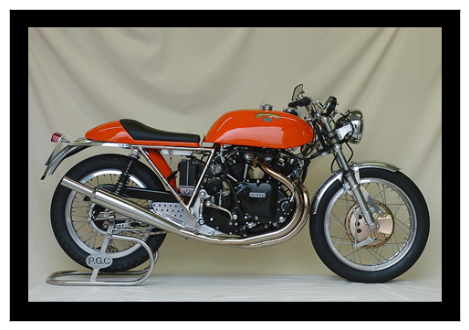

In [10]:
def mostrar(imagen):
    if len(imagen.shape) == 3:
        img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        img = imagen
        plt.imshow(img, cmap='Greys_r')
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

img = cv2.imread('data/motorcycle.bmp', cv2.IMREAD_UNCHANGED)
mostrar(my_copyMakeBorder(src=img, space=20, borderType='black'))

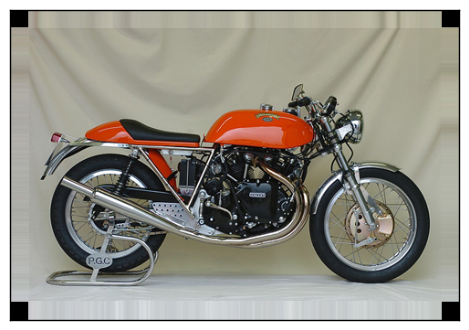

In [11]:
mostrar(my_copyMakeBorder(src=img, space=20, borderType='replicate'))

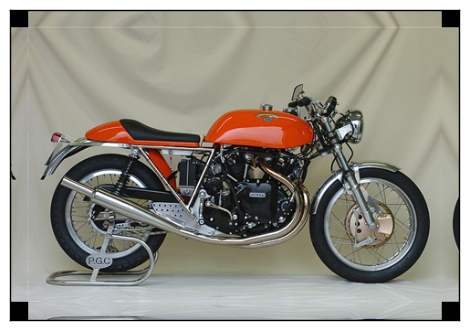

In [12]:
mostrar(my_copyMakeBorder(src=img, space=20, borderType='reflect'))

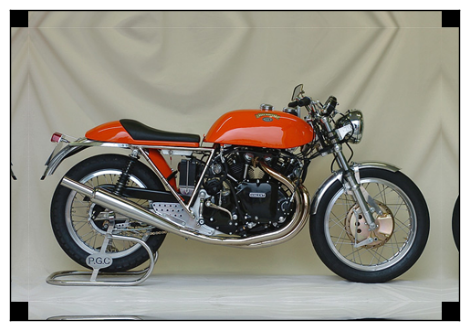

In [13]:
mostrar(my_copyMakeBorder(src=img, space=20, borderType='reflect_101'))

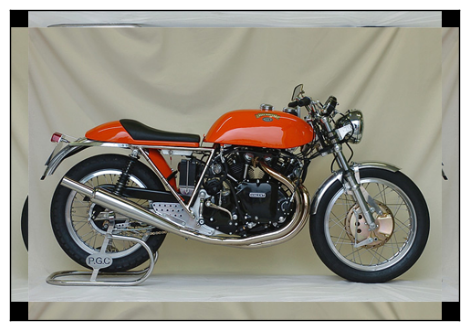

In [14]:
mostrar(my_copyMakeBorder(src=img, space=20, borderType='wrap'))

Se puede apreciar que en las esquinas no se aplica ningún borde. Este detalle se ha obviado debido a que una vez realizado el filtro se recorta el borde creado.

### Aplicar las funciones anteriores a una imagen separando canales si fuese necesario

Se han desarrollado dos funciones: `my_filter2D` y `my_filter2D_onechannel`. La primera función sirve como interfaz de la segunda.

In [15]:
# Función para aplicar la máscara 1D a una imagen con más de un canal
def my_filter2D(src, kernel, borderType):
    # en primer lugar comprobamos si la imagen es en color o en blanco y negro
    if len(src.shape) == 3:
        # si es en color, debemos separar sus canales
        canales = cv2.split(src)
        # y aplicar sobre cada uno de ellos el filtro
        for i in range(len(canales)):
            canales[i] = my_filter2D_onechannel(src=canales[i], kernel=kernel, borderType=borderType)
        # una vez hecho esto, los volvemos a juntar con merge
        img = cv2.merge(canales)
    else:
        # si solo tiene un canal, aplicamos directamente el filtro
        img = my_filter2D_onechannel(src=src, kernel=kernel, borderType=borderType)
    return img

# Función para aplicar la máscara 1D a un canal de la imagen
def my_filter2D_onechannel(src, kernel, borderType):
    mitad_mascara = floor(kernel.size/2)
    # En primer lugar, añadimos bordes a la imagen
    img_bordes = my_copyMakeBorder(src=src, space=mitad_mascara, borderType=borderType).astype(np.float64)
    # img_bordes = cv2.copyMakeBorder(src=src, top=mitad_mascara, bottom=mitad_mascara, left=mitad_mascara,
    #                                 right=mitad_mascara, borderType=borderType)
    img_aux = np.ones(img_bordes.shape, np.float64)*255
    # Después, aplicamos el kernel a cada trocito
    for j in range(mitad_mascara, img_bordes.shape[0]-mitad_mascara):
        for i in range(mitad_mascara,img_bordes.shape[1]-mitad_mascara):
            img_aux[j,i] = apply_kernel(img_bordes[j,i-mitad_mascara:i+1+mitad_mascara], kernel)
    img_bordes = img_aux.copy(order='F')
    img_aux = np.ones(img_bordes.shape, np.uint8)*255
    # Después, aplicamos el kernel a cada trocito
    for j in range(mitad_mascara, img_bordes.shape[1]-mitad_mascara):
        for i in range(mitad_mascara,img_bordes.shape[0]-mitad_mascara):
            img_aux[i,j] = apply_kernel(img_bordes[i-mitad_mascara:i+1+mitad_mascara,j], kernel)
    img_bordes = img_aux.copy(order='F')
    # Devolvemos la imagen con el filtro aplicado
    return img_bordes[mitad_mascara:-mitad_mascara, mitad_mascara:-mitad_mascara]

La función `my_filter2D` comprueba en primer lugar si la imagen es en color o en blanco y negro. Para ello, comprueba el tamaño del atributo `shape` de la imagen de entrada. A continuación, si la imagen resulta ser en color, separa sus canales usando la función `split` de _OpenCV_ y aplica el filtro gaussiano sobre cada canal. Por último, una vez aplicado el filtro sobre cada canal, se vuelven a juntar en una sola imagen usando la función `merge` de _OpenCV_. Si la imagen resulta ser en blanco y negro, se le aplica directamente el filtro.

La función `my_filter2D_onechannel` es la que aplica el filtro sobre un único canal. Para ello, calcula en primer lugar la mitad del tamaño de la máscara para saber el espacio que tiene que dejar en cada borde la imagen. Tras esto, aplica un borde (especificado por parámetro) a la imagen. Usando la imagen con bordes, empezamos a aplicar el filtro a la imagen usando la función `apply_kernel`, __primero por filas y después por columnas__. Me ha parecido mejor hacerlo así en vez de hacerlo en una función a parte y trasponer la imagen por cuestiones de eficiencia. 

A continuación se muesta cómo funciona la función.

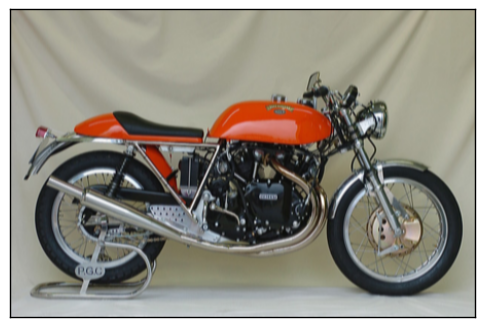

In [16]:
final_image = cv2.filter2D(src=img,ddepth=-1,kernel=mascara,borderType=cv2.BORDER_REPLICATE)
my_final_image = my_filter2D(src=img, kernel=my_mascara,borderType='replicate')
mostrar(final_image)

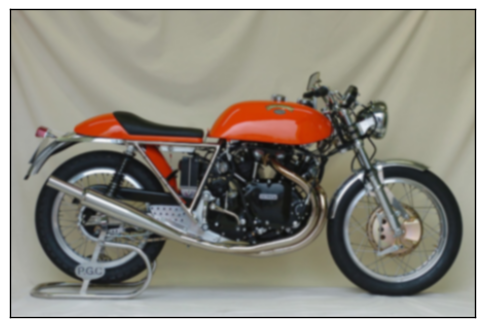

In [17]:
mostrar(my_final_image)

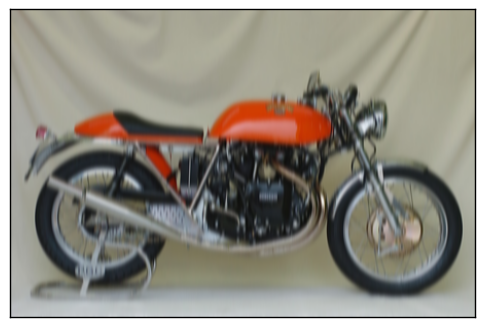

In [18]:
final_image2 = cv2.filter2D(src=img,ddepth=-1,kernel=mascara2,borderType=cv2.BORDER_REPLICATE)
my_final_image2 = my_filter2D(src=img, kernel=my_mascara2,borderType='replicate')
mostrar(final_image2)

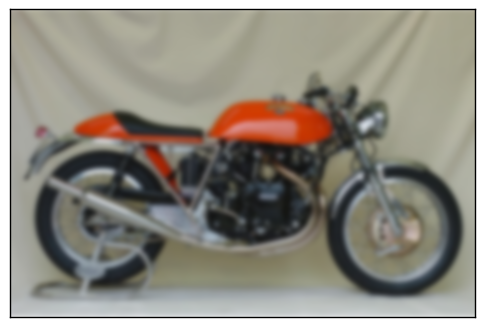

In [19]:
mostrar(my_final_image2)

En comparación con _OpenCV_, me da la sensación de que _OpenCV_ sólo aplica la máscara en una dimensión, ya que el desenfoque obtenido con _OpenCV_ da la sensación de movimiento vertical. En cambio, el resultado obtenido con la función `my_filter2D` sí que da la sensación de un desenfoque "uniforme".


# Apartado B

## Imágenes híbridas

Las imágenes híbridas son un efecto óptico en el cual engañamos al ojo haciéndole creer que ve una cosa distinta si mira la imagen de cerca o la mira de lejos. Para ello, mezclamos las __frecuencias altas__ de una imagen con las __frecuencias bajas__ de otra. 

A parte de la función de convolución (`my_filter2D`) desarrollada, he hecho dos más: una llamada `hybrid` que toma como parámetros dos imágenes y los distintos $\sigma$ que aplicar a cada una y otra llamada `make_collage` que sirve para hacer un collage a partir de varias imágenes.

Para hacer una imagen híbrida, he aplicado a ambas imágenes una máscara de convolución para obtener así las frecuencias bajas de cada una. Para obtener las frecuencias altas, he restado a la imagen original la imagen con las frecuencias bajas. Por último, para obtener la imagen híbrida, he sumado las frecuencias bajas de una imagen con las frecuencias altas de la otra imagen. 

He añadido a la función un parámetro para dejar que el usuario decida si quiere el resultado en forma de collage o no. En el caso de que el usuario quiera el resultado en forma de collage, obtendrá como resultado un collage con las tres imágenes: la imagen con frecuencias bajas, la imagen con frecuencias altas y la híbrida de ambas.


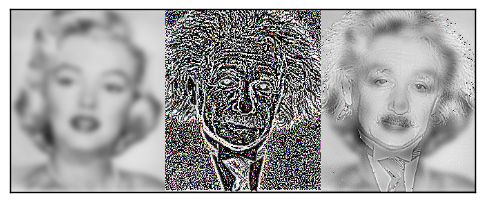

In [20]:
# def make_collage(lista_imagenes, lista_texto, space=450):
def make_collage(lista_imagenes):
    # inicializamos una matriz de 255s con el tamaño deseado
    if len(lista_imagenes[0].shape) == 3:
        # collage = np.ones((lista_imagenes[0].shape[0]+100,lista_imagenes[0].shape[1]*3,3), np.uint8)*255
        collage = np.ones((lista_imagenes[0].shape[0],lista_imagenes[0].shape[1]*3,3), np.uint8)*255
    else:
        # collage = np.ones((lista_imagenes[0].shape[0]+100,lista_imagenes[0].shape[1]*3), np.uint8)*255
        collage = np.ones((lista_imagenes[0].shape[0],lista_imagenes[0].shape[1]*3), np.uint8)*255

    dims = lista_imagenes[0].shape
    for i in range(len(lista_imagenes)):
        collage[0:dims[0], i*dims[1]:dims[1]*(1+i)] = lista_imagenes[i]#.copy(order='F')
        # cv2.putText(img=collage, text=lista_texto[i], org=(25+(space*i),dims[0]+70), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        #        fontScale=3, color=0)

    return collage

# def hybrid(img_alta, img_baja, space=210, sigma_alta=1.5, sigma_baja=4, blackwhite = False, collage = True):
def hybrid(img_alta, img_baja, sigma_alta=1.5, sigma_baja=4, blackwhite=False, collage=True):
    # obtenemos las máscara respectivas para cada imagen
    my_mascara_alto = my_getGaussianKernel(sigma=sigma_alta)
    my_mascara_bajo = my_getGaussianKernel(sigma=sigma_baja)
    # leemos las dos imágenes que vamos a mezclar
    if blackwhite:
        img = cv2.imread(img_alta, cv2.IMREAD_GRAYSCALE).astype(np.float64)
        img2 = cv2.imread(img_baja, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    else:
        img = cv2.imread(img_alta, cv2.IMREAD_UNCHANGED).astype(np.float64)
        img2 = cv2.imread(img_baja, cv2.IMREAD_UNCHANGED).astype(np.float64)
    # para quedarnos con las frecuencias altas de la imagen, restamos las frecuencias bajas que obtenemos con el
    # filtro gaussiano a la imagen original
    paso_alto = img - my_filter2D(src=img, kernel=my_mascara_alto, borderType='replicate')
    paso_bajo = my_filter2D(src=img2, kernel=my_mascara_bajo, borderType='replicate')
    # para obtener la imagen híbrida, sumamos las dos imágenes.
    if collage:
        # return make_collage([paso_bajo,paso_alto,paso_alto+paso_bajo],["Low","High","Both"],space)
        return make_collage([paso_bajo, paso_alto, paso_alto + paso_bajo])
    else:
        return paso_alto+paso_bajo

mostrar(hybrid('data/einstein.bmp','data/marilyn.bmp'))

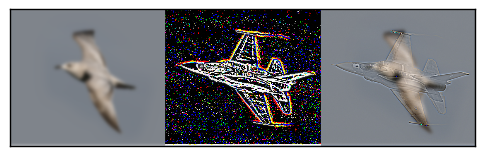

In [21]:
mostrar(hybrid('data/plane.bmp','data/bird.bmp', sigma_alta=2))

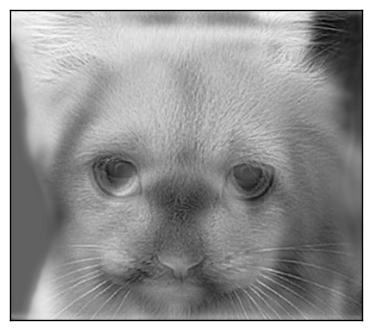

In [22]:
catdog = hybrid('data/cat.bmp','data/dog.bmp',sigma_alta=2.5, sigma_baja=5, blackwhite=True, collage=False)
mostrar(catdog)

Como se ve en las imágenes anteriores, si ves la imagen de cerca parece una cosa y si la miras desde lejos parece justo la contraria. Este efecto óptico se consigue porque cuando vemos algo de cerca lo identificamos mediante sus __frecuencias altas__ mientras que, cuando lo vemos de lejos, lo identificamos por sus __frecuencias bajas__.

# Apartado C
## Pirámides gaussianas

Las __pirámides gaussianas__ son un collage en el que se representa una misma imagen en distintas escalas: 1/1, 1/2, 1/4...

Para hacer la pirámide gaussiana de una imagen, he desarrollado dos funciones: `resize` para escalar una una imagen con un parámetro $scale$, de forma $\frac{1}{scale}$ y `piramide_gaussiana` para crear la pirámide.

En la función `piramide_gaussiana`, creo un canvas con tamaño:

$$ size_{canvas} = \bigg [ ancho_{canvas} + \frac{ancho_{canvas}}{2}, alto_{canvas} \bigg ]$$

Una vez creado el canvas, se coloca la imagen original en la parte izquierda y, se hace un bucle para colocar el resto de imágenes escaladas a la derecha. Se colocan las siguientes escalas: 1/2, 1/4, 1/8 y 1/16.

Es importante destacar que para escalar una imagen hay que seguir dos pasos: primero aplicar un filtro gaussiano para eliminar ruido y, después, redimensionar la imagen. Si no se hace esto, la imagen escalada tendrá demasiado ruido.

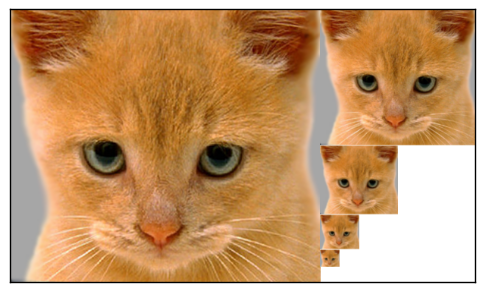

In [23]:
# Función para redimensionar una imagen 1/scala de su tamaño.
def resize(img, scale):
    # Para hacer un buen redimensionado. Debemos primero aplicar un filtro gaussiano a la imagen y después quedarnos con
    # las filas/columnas %scale. Por ejemplo si scale=2, sólo nos quedaríamos con las pares (una sí, una no, ....).
    img_blur = my_filter2D(src=img, kernel=my_getGaussianKernel(scale/2),borderType='replicate')
    # una vez desenfocada la imagen, creamos una nueva imagen para guardarla y nos quedamos con las filas/columnas %scale
    img_little = img_blur[range(0,img_blur.shape[0],scale)]
    img_little = img_little[:,range(0,img_blur.shape[1],scale)]

    return img_little

# Función para hacer un collage tipo pirámide gaussiana
def piramide_gaussiana(img, scale=5):
    # el tamaño del canvas debe ser ancho_img_original + 0.5*ancho_img_original x altura_img_original
    dims = img.shape
    if len(dims) == 3:
        piramide = np.ones((dims[0],dims[1]+floor(dims[1] * 0.5),3),np.uint8)*255
    else:
        piramide = np.ones((dims[0], dims[1] + floor(dims[1] * 0.5)),np.uint8) * 255

    # colocamos la primera imagen en tamaño original
    piramide[0:dims[0],0:dims[1]] = img
    # calculamos el lugar donde poner la segunda
    start_height = 0
    end_height = ceil(dims[0]/2)
    start_width = dims[1]   # este lugar será igual para todas las imágenes
    start_width -= 1
    little = img
    for i in range(2,scale+1):
        # calculamos la i-esima imagen
        little = resize(img=little, scale=2)
        # guardamos sus medidas
        dims = little.shape
        # la colocamos en el sitio calculado
        piramide[start_height:end_height,start_width:start_width+dims[1]] = little
        # calculamos dónde colocar la siguiente imagen
        start_height = end_height
        end_height = ceil(dims[0]/2) + start_height

    return piramide

mostrar(piramide_gaussiana(cv2.imread('data/cat.bmp', cv2.IMREAD_UNCHANGED)))

Las pirámides gaussianas vienen muy bien para ver imágenes híbridas a distintas escalas. Así, en la imagen más grande veremos las frecuencias altas de la imagen y en las escalas más pequeñas, veremos únicamente las frecuencias bajas.

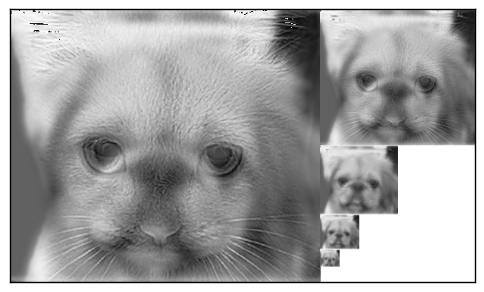

In [24]:
mostrar(piramide_gaussiana(catdog))

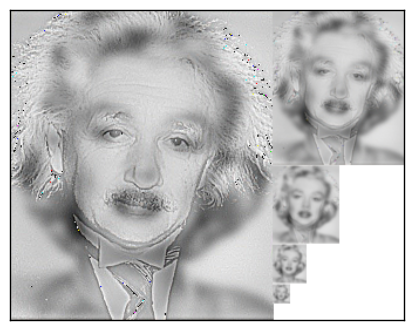

In [25]:
mostrar(piramide_gaussiana(hybrid('data/einstein.bmp', 'data/marilyn.bmp', collage=False)))

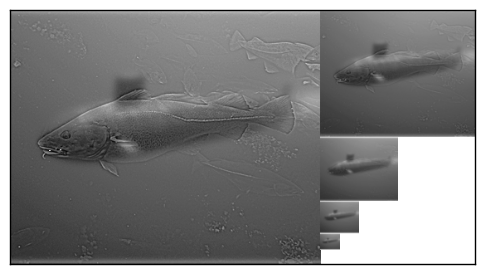

In [27]:
mostrar(piramide_gaussiana(hybrid('data/fish.bmp', 'data/submarine.bmp', collage=False, blackwhite=True)))

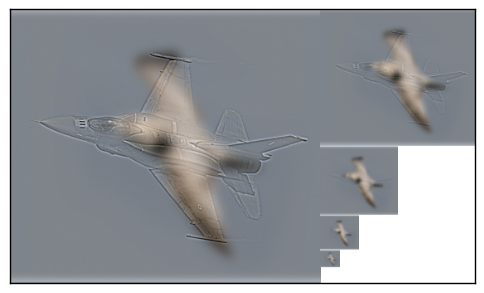

In [28]:
mostrar(piramide_gaussiana(hybrid('data/plane.bmp','data/bird.bmp', sigma_alta=1.5, sigma_baja=6, collage=False)))